In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from functions import *

folder_path = "test_cases"

Case 1 {0: 437536, 255: 418089} (925, 925)
Estimated Rotation Angle: 8.000007629394531
Case 2 {0: 389102, 255: 394717} (981, 799)
Case 3 {0: 433664, 255: 421961} (925, 925)
Case 4 {0: 453528, 255: 403947} (925, 927)
Case 5 {0: 481743, 255: 494352} (981, 995)
Case 6 {0: 255948, 255: 529232} (860, 913)
Case 7 {0: 375866, 255: 479759} (925, 925)
Case 8 {0: 395494, 255: 461982} (926, 926)
Case 9 {0: 439439, 255: 425461} (930, 930)
Case 10 {0: 401472, 255: 431841} (897, 929)
Case 11 {0: 424069, 255: 438971} (930, 928)
Case 12 {0: 464694, 255: 421722} (944, 939)
Case 13 {0: 376013, 255: 480537} (926, 925)
Estimated Rotation Angle: 21.00000762939453
Case 14 {0: 7876, 255: 8765} (129, 129)
Case 15 {0: 19939, 255: 21473} (203, 204)
Case 16 {0: 476006, 255: 441758} (958, 958)
Case 17 {0: 406703, 255: 448922} (925, 925)
Case 18 {0: 453024, 255: 402601} (925, 925)


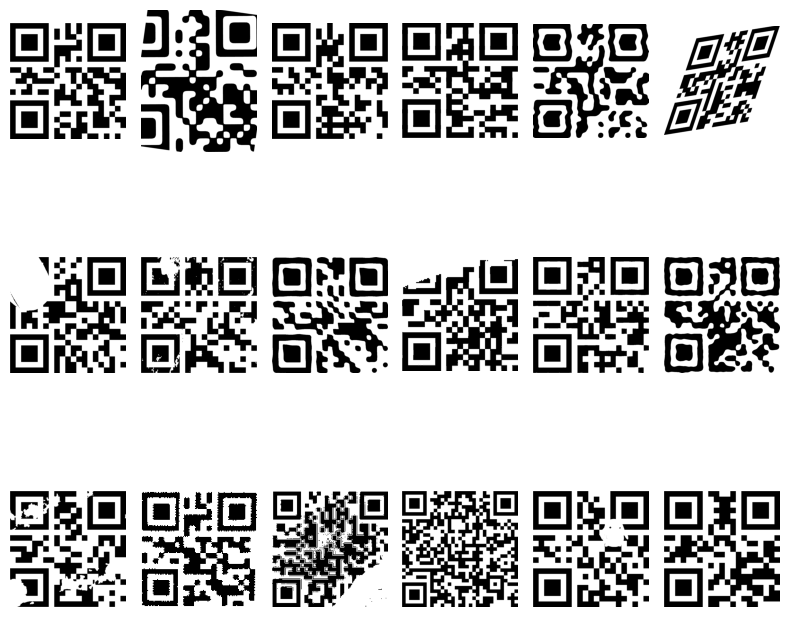

In [2]:
fig, axes = plt.subplots(3, 6, figsize=(8, 8))
for i, filename in enumerate(os.listdir(folder_path)):
    if i >= 18:
        break
    
    
    image_path = os.path.join(folder_path, filename)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    image_new = np.uint8(fix_sin_wave(image))

    # Initial Thresholding and Histogram Equalization
    hist_values = unique_pixel_values(image_new)
    sum_of_keys = sum(key for key in hist_values)
    keys_average = sum_of_keys / len(hist_values)
    _, image_new = cv2.threshold(image_new, keys_average - 24, keys_average + 24, cv2.THRESH_BINARY)
    image_new = cv2.equalizeHist(np.uint8(image_new))

    # If new image is corrupted (all black or all white), keep original for now
    hist_values = unique_pixel_values(image_new)
    if len(hist_values) == 1:
        image_new = image


    # By observation, 99% of QR images thresholding will have more white pixels than black pixels
    # So, if black pixels are more than white pixels, invert image
    hist_values = unique_pixel_values(image_new)

    # Needs rework (Broken)
    image_new = fix_inverted(image_new, hist_values)

    # Checking for extreme low/high brightess

    hist_values = unique_pixel_values(image_new)

    # Low Brightness fix (can be more generic by removing small noise using median filter)
    image_new = fix_low_brightness(image_new, hist_values)
    
    # High Brightness fix (can be more generic by removing small noise using median filter)
    image_new = fix_high_brightness(image_new, hist_values)

    # High Brightness fix (can be more generic by removing small noise using median filter)
    image_new = fix_high_brightness(image_new, hist_values)

    # After all above preprocessing, if an image still doesn't have any black or white pixel values, it is most probably a low contrast image
    # Preprocessing with average of key values as threshold to fix low contrast images
    hist_values = unique_pixel_values(image_new)
    image_new = fix_low_contrast(image_new, hist_values)

    # After all previous preprocessing all QR codes quiet zones should be pure white pixels only
    # If the first 5x5 window in image still contains more than 1 pixel value, then it must contain salt & pepper noise
    small_corner = unique_pixel_values(image_new[0:5][0:5])
    if len(small_corner) > 1:
        image_new = fix_salt_pepper(image)


    # DANGER ZONE
    ################################################################

    # Detect all three locator boxes to detect QR code frame
    locator_boxes = detect_locator_boxes(image_new)

    if locator_boxes:
        # Expand to encompass the entire QR code
        expanded_box = expand_to_qr_code(image_new, locator_boxes)

        # This function simulates a zoom effect to be able to frame smaller qr codes more accurately
        image_new = crop_to_bounding_box_margin(
            image_new, expanded_box, margin=50)

        # This function fixes tilt in images using Hough Lines, it works only for tilt angles less than 45
        image_new = fix_tilt(image_new)

        # Detect locator boxes again after zooming
        locator_boxes = detect_locator_boxes(image_new)

        # Get QR frame coordinates
        expanded_box = expand_to_qr_code(image_new, locator_boxes)

        # Draw QR frame
        x, y, w, h = expanded_box
        # cv2.rectangle(image_new, (x, y), (x + w, y + h), (0, 0, 0), 3)


        # Crop image to locator frame size
        image_new = crop_to_bounding_box(image_new, expanded_box)


    # FIX 6 HERE
    # image_new = fix_locator_box_skew(image_new)

    # rotate images that has clear 3 locator boxes (to be moved down)
    image_new = rotate_image(image_new)


    # Resizing for decoding
    #########################################

    # if image_new.shape > (924, 924):
    #     image_new = cv2.resize(image_new, (924, 924), interpolation=cv2.INTER_LINEAR)
    #     image_new = replace_with_median(image_new, 924)
    # elif image_new.shape > (672, 672):
    #     image_new = cv2.resize(image_new, (672, 672), interpolation=cv2.INTER_LINEAR)
    #     image_new = replace_with_median(image_new, 672)
    # elif image_new.shape > (420, 420):
    #     image_new = cv2.resize(image_new, (420, 420), interpolation=cv2.INTER_LINEAR)
    #     image_new = replace_with_median(image_new, 420)
    # else:
    #     image_new = cv2.resize(image_new, (168, 168), interpolation=cv2.INTER_LINEAR)
    #     image_new = replace_with_median(image_new, 168)



    # Apply Final thresholding to remove any noise pixels
    _, image_new = cv2.threshold(image_new, 64, 255, cv2.THRESH_BINARY)

    # Plot the image in the corresponding subplot
    row = i // 6
    col = i % 6
    axes[row, col].axis('off')
    axes[row, col].imshow(image_new, cmap='gray')

    hist_values = unique_pixel_values(image_new)
    print(f"Case {i+1}", hist_values, image_new.shape)

    # save each image
    cv2.imwrite(f"output_images/{filename}", image_new)

plt.tight_layout()
plt.show()

In [3]:
def load_image(image_path) -> np.ndarray:
    return cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)


images = [(filename, load_image(os.path.join("output_images", filename)))
              for filename in os.listdir("output_images")]

In [4]:
new_width = 1008
new_height = 1008
for filename, image in images:
    # Resize the image
    resized_image = cv2.resize(image, (new_width, new_height))

    # Save the resized image (overwrite the original)
    cv2.imwrite(os.path.join("resized", f"resized_{filename}"), resized_image)

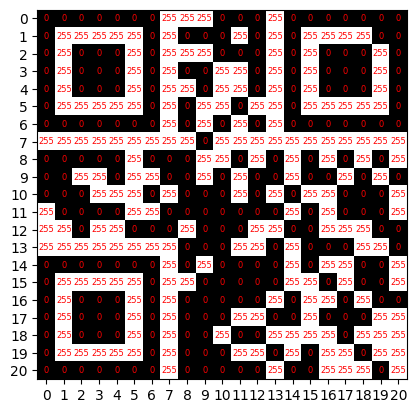

In [5]:
filepath = "resized_012-mal7-w-felfel.png"

img = cv2.imread(
    f"resized/{filepath}", cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap='gray')

# split the image into 21 columns and 21 rows, each of 48x48 pixels
rows = np.vsplit(img, 21)
cells = np.array([np.hsplit(row, 21) for row in rows])

# # plot them, it is possible that some cells are all zeros (black) or all 255 (white)
# fig, axes = plt.subplots(21, 21, figsize=(8, 8))
# for i in range(21):
#     for j in range(21):
#         axes[i, j].axis('off')
#         axes[i, j].imshow(cells[i][j], cmap='gray', aspect='auto', vmin=0, vmax=255)



# # show grid lines between cells
# for ax in axes.flatten():
#     for spine in ax.spines.values():
#         spine.set_visible(True)
#         spine.set_color('red')
#         spine.set_linewidth(0.5)
# plt.tight_layout()
# plt.show()

new_image = np.zeros((21, 21), dtype=np.uint8)
for i in range(cells.shape[0]):
    for j in range(cells.shape[1]):
        # make all the pixels in the cell either black or white
        _, cell = cv2.threshold(cells[i, j], 127, 255, cv2.THRESH_BINARY)

        # show new hist
        hist_values = unique_pixel_values(cell)

        # get first quartile of cell
        q1 = np.percentile(cell, 50)

        new_image[i, j] = q1

plt.yticks(np.arange(0, 21, 1))
plt.xticks(np.arange(0, 21, 1))
# show values inside each cell
for i in range(21):
    for j in range(21):
        # decrease font size
        plt.text(j, i, new_image[i, j], ha='center',
                 va='center', color='red', fontsize=6)
plt.imshow(new_image, cmap='gray')

In [51]:
cell.shape

(48, 48)

In [52]:
new_image[1, 1]

255

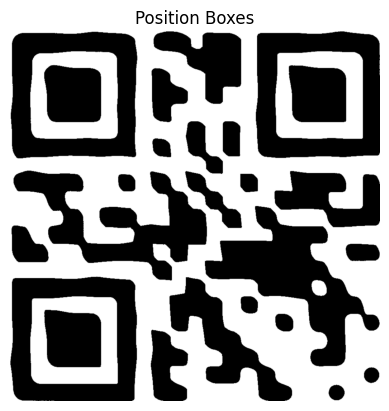

In [53]:
img = cv2.imread(
    "resized/resized_009-My-phone-fell-while-taking-this-one-...-or-did-it.png")

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Threshold the image to obtain a binary image
_, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# Find contours in the binary image
contours, _ = cv2.findContours(
    thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours based on their area to identify the position boxes
position_boxes = []
for contour in contours:
    area = cv2.contourArea(contour)
    if 100 < area < 1000:  # Adjust the area threshold as needed
        position_boxes.append(contour)

canvas = img.copy()
cv2.drawContours(canvas, position_boxes, -1, (0, 255, 0), 2)
canvas_rgb = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)

# Plot the image with contours using Matplotlib
plt.imshow(canvas_rgb)
plt.title('Position Boxes')
plt.axis('off')
plt.show()